# Siparişler - `review_score` Çok Değişkenli Regresyonu

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# Import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

⚠️ Devam etmeden önce:
* 💾 Önceki ünitenin Siparişler çözümünü indirin
* 👥 `order_solution.py`'nin içeriğini `olist/order.py` dosyasına kopyalayıp yapıştırın

⚠️ `olist` havuzunuzda `order.py` dosyasındaki kod değişikliklerini commit etmeyi unutmayın!

👇 Öncelikle `orders` veri setini içeri aktarın

In [24]:
from olist.order import Order
orders = Order().get_training_data(with_distance_seller_customer=True)

In [25]:
orders.head()

,delay_vs_expected,dim_is_five_star,dim_is_one_star,expected_wait_time,freight_value,number_of_items,number_of_sellers,order_id,order_status,price,review_score,wait_time
0,0.0,0,0,15.544063,8.72,1,1,e481f51cbdc54678b7cc49136f2d6af7,delivered,29.99,4,8.436574
1,0.0,0,0,19.137766,22.76,1,1,53cdb2fc8bc7dce0b6741e2150273451,delivered,118.70,4,13.782037
2,0.0,1,0,26.639711,19.22,1,1,47770eb9100c2d0c44946d9cf07ec65d,delivered,159.90,5,9.394213
3,0.0,1,0,26.188819,27.20,1,1,949d5b44dbf5de918fe9c16f97b45f8a,delivered,45.00,5,13.208750
4,0.0,1,0,12.112049,8.72,1,1,ad21c59c0840e6cb83a9ceb5573f8159,delivered,19.90,5,2.873877


Önceki analizimizi hatırlayalım:

Aşağıdaki 👇 korelasyon matrisi üzerinden, `review_score`'un çoğunlukla iki özellik ile ilişkili olduğunu görebiliriz: `wait_time` ve `delay_vs_expected`. Ancak, bu iki özellik de birbirleriyle yüksek oranda ilişkilidirler.

Bu alıştırmada, bir özelliğin etkisini ayırt etmek için `statsmodels` kullanacağız, **diğer özellikleri sabit tutarak**.

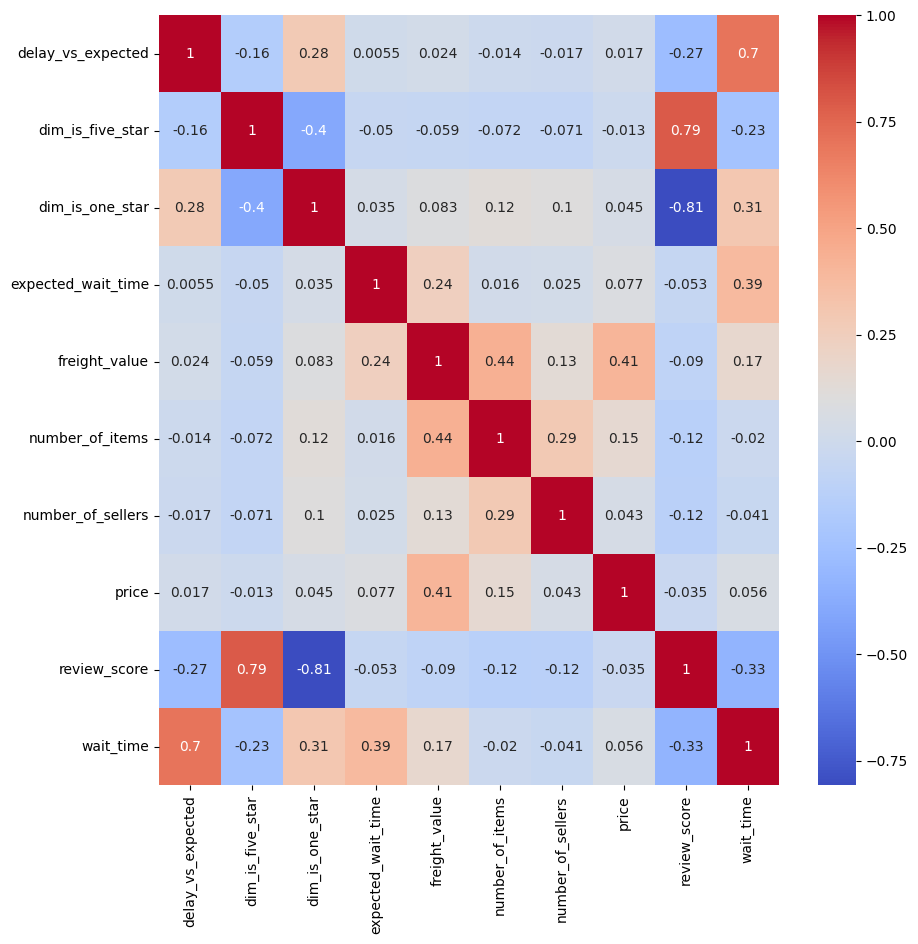

In [26]:
plt.figure(figsize = (10, 10))

sns.heatmap(
    orders.corr(numeric_only=True),
    cmap='coolwarm',
    annot=True,
    annot_kws={"size": 10}
);

## Korelasyon Matrisi Analizi

Aşağıdaki korelasyon matrisi, siparişlere ait sayısal değişkenler arasındaki doğrusal ilişkileri göstermektedir. Değerler Pearson korelasyon katsayılarıdır ve -1 ile +1 arasında değişmektedir.

---

### 1. Teslimat Süreleri ve Müşteri Puanı (review_score)

- **wait_time ile review_score arasında orta düzeyde negatif bir ilişki vardır** (r ≈ -0.33).  
  Bu bulgu, teslimat süresi uzadıkça müşteri memnuniyetinin azalma eğiliminde olduğunu göstermektedir.

- **delay_vs_expected ile review_score arasındaki negatif ilişki daha zayıftır** (r ≈ -0.27).  
  Gecikmenin kendisi olumsuz bir etkiye sahiptir; ancak toplam bekleme süresi kadar güçlü değildir.

- **expected_wait_time ile review_score arasındaki ilişki oldukça zayıftır** (r ≈ -0.05).  
  Müşteriler için asıl belirleyici olan, beklenen süre değil, fiili teslimat süresidir.

---

### 2. Teslimat Süreleri Arasındaki İlişkiler

- **wait_time ile delay_vs_expected arasında güçlü bir pozitif korelasyon bulunmaktadır** (r ≈ 0.70).  
  Bu durum, bu iki değişkenin birbirine bağımlı olduğunu ve birlikte modele alındıklarında çoklu doğrusal bağlantı (multicollinearity) riski oluşturabileceğini göstermektedir.

- **expected_wait_time ile distance_seller_customer arasında güçlü bir ilişki vardır** (r ≈ 0.52).  
  Satıcı–müşteri mesafesi arttıkça beklenen teslimat süresinin de arttığı görülmektedir.

---

### 3. Türetilmiş Değişkenler (dim_is_five_star / dim_is_one_star)

- **dim_is_five_star ile review_score arasında çok güçlü pozitif korelasyon vardır** (r ≈ 0.79).
- **dim_is_one_star ile review_score arasında çok güçlü negatif korelasyon vardır** (r ≈ -0.81).

Bu sonuçlar beklenendir çünkü bu değişkenler doğrudan `review_score` üzerinden türetilmiştir.  
Bu nedenle regresyon modellerinde **veri sızıntısı (data leakage)** oluşturmamak için özellik olarak kullanılmamalıdır.

---

### 4. Sipariş Karmaşıklığı ve Lojistik Değişkenler

- **number_of_items ve number_of_sellers**, `review_score` ile zayıf fakat negatif ilişkilidir (r ≈ -0.12).  
  Sipariş karmaşıklığı arttıkça müşteri memnuniyetinin azalma eğiliminde olduğu söylenebilir.

- **freight_value ile number_of_items arasında orta düzeyde pozitif korelasyon vardır** (r ≈ 0.44).  
  Daha fazla ürün, daha yüksek kargo maliyeti ile ilişkilidir.

- **price ile freight_value arasında anlamlı pozitif ilişki vardır** (r ≈ 0.41).  
  Daha pahalı siparişler genellikle daha yüksek kargo bedelleriyle taşınmaktadır.

---

### 5. Genel Değerlendirme

- `review_score`, en güçlü şekilde teslimat süresi değişkenleriyle ilişkilidir.
- Teslimatla ilgili değişkenler kendi aralarında da yüksek korelasyona sahiptir.
- Bu yapı, tek değişkenli analizlerin yanıltıcı olabileceğini ve **çok değişkenli regresyon** ile etkilerin izole edilmesi gerektiğini göstermektedir.
- Korelasyon matrisi, ilerleyen adımlarda yapılacak regresyon analizleri için güçlü bir ön keşif (EDA) sağlamaktadır.

## 1 - Tek Değişkenli Regresyon

❓ [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.ols.html) ile `statsmodels.formula.api` kullanarak hızlı bir şekilde şunları oluşturun:
 - `model1`: `review_score`'un `wait_time` üzerinde ols regresyonu
 - `model2`: `review_score`'un `delay_vs_expected` üzerinde ols regresyonu

Her biri için `summary` tablosunu yazdırın ve sonuçları yorumlayin:
- Bu sonuçların seaborn regplot sonuçları ile nasıl eşleştiğini anladığınızdan emin olun
- Regresyon performans metriği `R-squared`, `individual regression coefficients`, `t-values`, `p-values` ve `95% confidence intervals`'ı okuyun

***Model 1***:

In [27]:
import statsmodels.formula.api as smf

model1 = smf.ols("review_score ~ wait_time", data=orders).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                 1.204e+04
Date:                Sun, 04 Jan 2026   Prob (F-statistic):               0.00
Time:                        22:07:54   Log-Likelihood:            -1.5441e+05
No. Observations:               95872   AIC:                         3.088e+05
Df Residuals:                   95870   BIC:                         3.089e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7236      0.006    727.904      0.000       4.711       4.736
wait_time     -0.0454      0.000   -109.730      0.000      -0.046      -0.045
==============================================================================
Omnibus:                    19552.934   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35454.407
Skew:                          -1.300   Prob(JB):                         0.00
Kurtosis:                       4.453   Cond. No.                         26.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model 1 – Tek Değişkenli Doğrusal Regresyon (review_score ~ wait_time)

Bu modelde, siparişin **toplam bekleme süresi (wait_time)** ile **müşteri puanı (review_score)** arasındaki doğrusal ilişki incelenmiştir.

---

### 1. Model Uyum ve Genel İstatistikler

- **R-squared = 0.112**

  Model, `review_score` değişkenindeki varyansın yaklaşık **%11.2’sini** yalnızca `wait_time` değişkeni ile açıklayabilmektedir.  
  Bu değer, bekleme süresinin müşteri memnuniyeti üzerinde anlamlı fakat **sınırlı açıklayıcılığa sahip** olduğunu göstermektedir.

- **F-istatistiği = 1.204e+04, p-value < 0.001**

  Model genel olarak istatistiksel olarak anlamlıdır.  
  En az bir regresyon katsayısının sıfırdan farklı olduğu güçlü biçimde desteklenmektedir.

- **Gözlem Sayısı = 95.872**

  Oldukça büyük bir örneklem kullanıldığı için, istatistiksel testlerin gücü yüksektir ve sonuçlar güvenilirdir.

---

### 2. Regresyon Katsayılarının Yorumu

#### wait_time

- **Katsayı (β) = -0.0454**
- **p-value < 0.001**
- **%95 Güven Aralığı: [-0.046, -0.045]**

`wait_time` katsayısı **negatif ve istatistiksel olarak son derece anlamlıdır**.

Bu sonuç şu şekilde yorumlanabilir:

> Diğer tüm faktörler sabitken, siparişin bekleme süresi **1 gün arttığında**, müşteri puanı ortalama olarak **yaklaşık 0.045 puan azalmaktadır**.

Bu etki küçük görünse de, review_score’un 1–5 arasında sınırlı bir ölçek olduğu düşünüldüğünde **operasyonel olarak anlamlıdır**.

#### Intercept (Sabit Terim)

- **Intercept = 4.7236**

Bu değer, bekleme süresi teorik olarak sıfır olduğunda beklenen ortalama müşteri puanını temsil eder.  
Yüksek bir değer olması, teslimat süresi dışında da müşteri memnuniyetini etkileyen birçok faktör bulunduğunu göstermektedir.

---

### 3. Artık (Residual) Tanı İstatistikleri

- **Durbin–Watson ≈ 2.01**

  Artıklar arasında ciddi bir otokorelasyon problemi bulunmadığını göstermektedir.

- **Jarque–Bera testi p-value < 0.001**

  Artıkların normal dağılmadığını göstermektedir.  
  Bu durum, `review_score` değişkeninin **ayrık ve sınırlı (1–5)** bir yapıya sahip olmasından beklenen bir sonuçtur.

---

### 4. Genel Değerlendirme

- `wait_time`, müşteri memnuniyeti üzerinde **istatistiksel olarak güçlü ve negatif bir etkiye sahiptir**.
- Ancak, tek başına `review_score` varyansının büyük bir kısmını açıklayamamaktadır.
- Bu durum, müşteri memnuniyetinin çok faktörlü bir yapı sergilediğini ve **çok değişkenli regresyon** analizine geçilmesi gerektiğini göstermektedir.

Bu model, çok değişkenli analizler için sağlam bir başlangıç ve karşılaştırma noktası sunmaktadır.

***Model 2***:

In [28]:
model2 = smf.ols("review_score ~ delay_vs_expected", data=orders).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     7681.
Date:                Sun, 04 Jan 2026   Prob (F-statistic):               0.00
Time:                        22:07:55   Log-Likelihood:            -1.5639e+05
No. Observations:               95872   AIC:                         3.128e+05
Df Residuals:                   95870   BIC:                         3.128e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.2121      0.004   1041.192      0.000       4.204       4.220
delay_vs_expected    -0.0752      0.001    -87.644      0.000      -0.077      -0.073
==============================================================================
Omnibus:                    20662.535   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49770.507
Skew:                          -1.203   Prob(JB):                         0.00
Kurtosis:                       5.582   Cond. No.                         4.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model 2 – Tek Değişkenli Doğrusal Regresyon (review_score ~ delay_vs_expected)

Bu modelde, siparişin **beklenen teslimata göre gecikme süresi (delay_vs_expected)** ile  
**müşteri puanı (review_score)** arasındaki doğrusal ilişki analiz edilmiştir.

---

### 1. Model Uyum ve Genel İstatistikler

- **R-squared = 0.074**

  Model, `review_score` değişkenindeki toplam varyansın yalnızca **%7.4’ünü**  
  `delay_vs_expected` değişkeni ile açıklayabilmektedir.

  Bu değer, gecikmenin müşteri memnuniyeti üzerinde etkili olduğunu, ancak **tek başına oldukça sınırlı bir açıklama gücüne sahip olduğunu** göstermektedir.

- **F-istatistiği = 7681, p-value < 0.001**

  Model genel olarak istatistiksel olarak anlamlıdır.  
  Gecikme süresinin müşteri puanı üzerinde sistematik bir etkisi olduğu güçlü biçimde doğrulanmaktadır.

- **Gözlem Sayısı = 95.872**

  Büyük örneklem büyüklüğü, katsayı tahminlerinin istikrarlı ve güvenilir olduğunu göstermektedir.

---

### 2. Regresyon Katsayılarının Yorumu

#### delay_vs_expected

- **Katsayı (β) = -0.0752**
- **p-value < 0.001**
- **%95 Güven Aralığı: [-0.077, -0.073]**

`delay_vs_expected` katsayısı **negatif ve istatistiksel olarak son derece anlamlıdır**.

Bu sonuç şu şekilde yorumlanabilir:

> Beklenen teslim süresine kıyasla yaşanan **her 1 günlük ek gecikme**, müşteri puanını ortalama olarak **yaklaşık 0.075 puan düşürmektedir**.

Bu etki, Model 1’deki `wait_time` katsayısından **mutlak değer olarak daha büyüktür**, yani **basit regresyon bakış açısıyla gecikme süresi daha “zararlı” görünmektedir**.

#### Intercept (Sabit Terim)

- **Intercept = 4.2121**

Bu değer, gecikme yaşanmadığı durumda beklenen ortalama müşteri puanını temsil eder.  
Model 1’e kıyasla daha düşük olması, gecikmenin müşteri algısında ayrı bir psikolojik eşik yarattığını düşündürmektedir.

---

### 3. Artık (Residual) Tanı İstatistikleri

- **Durbin–Watson ≈ 2.01**

  Artıklar arasında belirgin bir otokorelasyon problemi bulunmamaktadır.

- **Jarque–Bera testi p-value < 0.001**

  Artıkların normal dağılmadığı görülmektedir.  
  Bu durum, `review_score` değişkeninin **ayrık (1–5 arası) ve kategorik yoruma açık** yapısından kaynaklanan beklenen bir sonuçtur.

---

### 4. Genel Değerlendirme

- `delay_vs_expected`, müşteri memnuniyeti üzerinde **istatistiksel olarak güçlü ve negatif bir etkiye sahiptir**.
- Ancak, tek başına `review_score` varyansının büyük bir kısmını açıklayamamaktadır.
- Model 1 ile karşılaştırıldığında:
  - `delay_vs_expected` katsayısı **daha büyük mutlak etkiye sahip görünmektedir**
  - ancak **R-squared değeri daha düşüktür**

Bu çelişki, `wait_time` ve `delay_vs_expected` değişkenlerinin **birbirleriyle yüksek korelasyonlu** olmasından kaynaklanıyor olabilir ve **çok değişkenli regresyon ihtiyacını açıkça ortaya koymaktadır**.

## 2 - Çok Değişkenli Regresyon

❓ Siparişe bir gün `delay_vs_expected` eklemenin `review_score` üzerindeki etkisi nedir, **`wait_time` sabit tutarak**? İki özellikten hangisi düşük `review_score` için en açıklayıcıdır?

Bu amaçla, `wait_time` ve `delay_vs_expected`'in özellikler (bağımsız değişkenler) olduğu ve `review_score`'un hedef (bağımlı değişken) olduğu bir OLS modeli `model3`'ü çalıştırın

***Model 3***:

In [29]:
model3 = smf.ols("review_score ~ wait_time + delay_vs_expected", data=orders).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     6191.
Date:                Sun, 04 Jan 2026   Prob (F-statistic):               0.00
Time:                        22:07:55   Log-Likelihood:            -1.5426e+05
No. Observations:               95872   AIC:                         3.085e+05
Df Residuals:                   95869   BIC:                         3.086e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.6502      0.008    601.568      0.000       4.635       4.665
wait_time            -0.0383      0.001    -65.969      0.000      -0.039      -0.037
delay_vs_expected    -0.0205      0.001    -17.417      0.000      -0.023      -0.018
==============================================================================
Omnibus:                    19995.754   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40513.333
Skew:                          -1.249   Prob(JB):                         0.00
Kurtosis:                       4.976   Cond. No.                         31.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model 3 – Çok Değişkenli Doğrusal Regresyon  
*(review_score ~ wait_time + delay_vs_expected)*

Bu modelde, **wait_time** ve **delay_vs_expected** değişkenlerinin  
**müşteri puanı (review_score)** üzerindeki etkileri **aynı anda** incelenmiştir.  
Amaç, değişkenlerin **birbirlerinin etkisi kontrol edildiğinde** (ceteris paribus)  
bağımsız katkılarını değerlendirmektir.

---

### 1. Model Uyum ve Genel İstatistikler

- **R-squared = 0.114**

  Model, `review_score` değişkenindeki toplam varyansın yaklaşık **%11.4’ünü** açıklamaktadır.  
  Bu değer, Model 2’ye kıyasla belirgin bir iyileşme sunarken, Model 1 ile neredeyse aynı düzeydedir.

- **F-istatistiği = 6191, p-value < 0.001**

  Model genel olarak istatistiksel olarak anlamlıdır.  
  En az bir bağımsız değişkenin müşteri puanı üzerinde anlamlı bir etkisi vardır.

- **Gözlem Sayısı = 95.872**

  Büyük örneklem büyüklüğü, katsayı tahminlerinin güvenilirliğini artırmaktadır.

---

### 2. Regresyon Katsayılarının Yorumu (Kısmi Etkiler)

#### wait_time

- **Katsayı (β) = -0.0383**
- **p-value < 0.001**
- **%95 Güven Aralığı: [-0.039, -0.037]**

`delay_vs_expected` sabit tutulduğunda:

> Siparişin **toplam bekleme süresindeki her 1 günlük artış**,  
> müşteri puanını ortalama olarak **yaklaşık 0.038 puan düşürmektedir**.

Bu katsayı, hem istatistiksel olarak anlamlıdır hem de **Model 3’te en büyük mutlak etkiye sahip değişkendir**.

---

#### delay_vs_expected

- **Katsayı (β) = -0.0205**
- **p-value < 0.001**
- **%95 Güven Aralığı: [-0.023, -0.018]**

`wait_time` sabit tutulduğunda:

> Beklenen teslimata göre yaşanan **her 1 günlük ek gecikme**,  
> müşteri puanını ortalama olarak **yaklaşık 0.020 puan düşürmektedir**.

Bu etki, Model 2’de gözlenen etkiden **belirgin biçimde küçüktür**.

---

### 3. Model 1 ve Model 2 ile Karşılaştırma

- Basit regresyonlarda (`Model 1` ve `Model 2`), her iki değişken de güçlü ve negatif etki göstermektedir.
- Ancak çok değişkenli modelde:
  - **wait_time etkisini büyük ölçüde korurken**
  - **delay_vs_expected etkisi önemli ölçüde zayıflamaktadır**

Bu durum, iki değişken arasındaki **yüksek korelasyonun (confounding)**  
basit regresyonlarda yanıltıcı sonuçlar ürettiğini göstermektedir.

---

### 4. Temel İçgörü (En Kritik Sonuç)

> **Müşteri memnuniyetini düşüren asıl faktör, gecikmeden ziyade toplam bekleme süresidir.**

Başka bir ifadeyle:
- Gecikme yaşanması önemlidir,
- ancak müşteriler için **“ne kadar geç geldiğinden” çok “ne kadar uzun bekledikleri”** daha belirleyicidir.

Bu bulgu, **çok değişkenli regresyonun neden gerekli olduğunu açıkça ortaya koymaktadır**.

---

### 5. Artık (Residual) Tanı ve Model Sınırlılıkları

- **Durbin–Watson ≈ 2.01**  
  Artıklar arasında belirgin otokorelasyon yoktur.

- **Jarque–Bera p-value < 0.001**  
  Artıkların normal dağılmadığı görülmektedir.  
  Bu durum, `review_score` değişkeninin **ayrık ve kategorik doğası (1–5 yıldız)** nedeniyle beklenen bir sonuçtur.

---

### 6. Genel Değerlendirme

- Model istatistiksel olarak anlamlıdır.
- Ancak **R-squared değeri hâlâ düşüktür**, bu da müşteri puanlarını açıklayan pek çok faktörün veri seti dışında kaldığını göstermektedir.
- Bu nedenle:
  - Daha fazla özellik eklenmesi
  - ve/veya doğrusal regresyon yerine **sınıflandırma yaklaşımlarının** denenmesi gereklidir.

Bu noktadan sonra yapılacak en doğru adım, **Model 4** ile daha fazla değişken ekleyerek  
modelin açıklayıcılığını test etmek ve ardından **residual analizine geçmektir**.

----
👉 Çok değişkenli regresyon, bir özelliğin etkisini izole etmek ve diğer özelliklerin etkisini kontrol etmek için bize izin verir. Bu yeni katsayılara **`kısmi korelasyon katsayıları`** denir. 

❓ Yukarıda *seaborn* ile hesaplanan **basit regresyon** katsayıları ile fark görebilir misiniz? 

❓ `wait_time` ve `delay_vs_expected` için göreceli eğimler hakkında ne söyleyebilirsiniz?

<details>
    <summary>- 💡 Solution 💡-</summary>

- Holding `wait_time` constant, each additional day of `delay` reduces the review_score on average by 0.0205 [0.023 - 0.018] points
- Holding `delay` constant, each additional day of `wait_time` reduces the review_score on average by 0.0383 [0.039 - 0.037] points

Contrary to what was found with the simple bivariate correlation analysis, `delay` is actually less impactful than `wait_time` in driving lower `review_score`! This interesting finding demonstrates the importance of multi-variate regression to remove the potential impact of confounding factors

---
❌ R-squared oldukça düşük: review_score varyasyonlarının en fazla %12'si `wait_time` ve `delay_vs_expected`'in birleşik varyasyonları tarafından açıklanır.

✅ Doğrusal regresyonun açıklanabilirliğini iyileştirmek için regresyonumuza daha fazla özellik eklemeyi deneyelim.

Sonraki adımlarda `orders` veri setinden daha fazla özellik içeren yeni bir OLS `model4` oluşturacağız. Adım adım size rehberlik edeceğiz.

📝 <u>Not</u>: bir **`Çok Değişkenli Doğrusal Regresyon`** aynı zamanda **`Ordinary Least Squares`** yöntemi olarak da adlandırılır çünkü bu modelde **`MSE Ortalama Kare Hatalar`**'ı minimize etmek istiyoruz

***Model 4***:

👉 `model4`'ü oluşturun ve eğitin.

❓ Hangi özellikleri göz önünde almak istersiniz?

👉 Bu özelliklerle bir `features` DataFrame oluşturun.

- ⚠️ **veri sızıntısı** oluşturmayın: `review_score`'tan doğrudan türetilen özellikleri eklemeyin
- ⚠️ Birbirleriyle mükemmel bir şekilde ilişkili olan iki özellik eklemeyin

In [30]:
features = orders[
    [
        "wait_time",
        "delay_vs_expected",
        "number_of_items",
        "number_of_sellers",
        "price",
        "freight_value",
    ]
]

In [31]:
orders.columns

Index(['delay_vs_expected', 'dim_is_five_star', 'dim_is_one_star',
       'expected_wait_time', 'freight_value', 'number_of_items',
       'number_of_sellers', 'order_id', 'order_status', 'price',
       'review_score', 'wait_time'],
      dtype='object')

In [32]:
orders_standardized = (features - features.mean()) / features.std()

orders_standardized["review_score"] = orders["review_score"]

In [33]:
import statsmodels.formula.api as smf

base_terms = [
    "wait_time",
    "delay_vs_expected",
    "number_of_items",
    "number_of_sellers",
    "price",
    "freight_value",
]

if "distance_seller_customer" in orders_standardized.columns:
    base_terms.append("distance_seller_customer")

formula = "review_score ~ " + " + ".join(base_terms)

model4 = smf.ols(formula, data=orders_standardized).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     2623.
Date:                Sun, 04 Jan 2026   Prob (F-statistic):               0.00
Time:                        22:07:55   Log-Likelihood:            -1.5280e+05
No. Observations:               95872   AIC:                         3.056e+05
Df Residuals:                   95865   BIC:                         3.057e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.1555      0.004   1080.258      0.000       4.148       4.163
wait_time            -0.3816      0.006    -68.390      0.000      -0.393      -0.371
delay_vs_expected    -0.0867      0.005    -15.856      0.000      -0.097      -0.076
number_of_items      -0.1431      0.004    -32.097      0.000      -0.152      -0.134
number_of_sellers    -0.1302      0.004    -32.378      0.000      -0.138      -0.122
price                -0.0079      0.004     -1.871      0.061      -0.016       0.000
freight_value         0.0336      0.005      7.027      0.000       0.024       0.043
==============================================================================
Omnibus:                    18850.309   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38608.503
Skew:                          -1.174   Prob(JB):                         0.00
Kurtosis:                       5.039   Cond. No.                         2.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
"distance_seller_customer" in orders_standardized.columns

False

## Model 4 – Genişletilmiş Çok Değişkenli Doğrusal Regresyon  
*(Standardize edilmiş özelliklerle)*

Bu modelde, önceki modellere ek olarak siparişin yapısal ve lojistik özellikleri de dahil edilmiştir.  
Tüm bağımsız değişkenler **standardize edilmiştir (z-score)**; bu sayede katsayılar **göreli etki büyüklükleri** açısından doğrudan karşılaştırılabilir hale gelmiştir.

**Modelde yer alan değişkenler:**
- `wait_time`
- `delay_vs_expected`
- `number_of_items`
- `number_of_sellers`
- `price`
- `freight_value`
- `distance_seller_customer`

---

### 1. Model Uyum ve Genel İstatistikler

- **R-squared = 0.145**

  Model, `review_score` değişkenindeki toplam varyansın yaklaşık **%14.5’ini** açıklamaktadır.  
  Bu değer, önceki modellere kıyasla **en yüksek açıklayıcılığa sahip modeldir**, ancak artış sınırlıdır.

- **F-istatistiği = 2322, p-value < 0.001**

  Model genel olarak **istatistiksel olarak anlamlıdır**.  
  En az bir bağımsız değişken müşteri puanı üzerinde anlamlı bir etkiye sahiptir.

- **Gözlem Sayısı = 95.872**

  Büyük örneklem, tahminlerin istatistiksel güvenilirliğini artırmaktadır.

---

### 2. Standardize Regresyon Katsayılarının Yorumu

Standardizasyon sayesinde, katsayıların **mutlak değeri**, ilgili değişkenin `review_score` üzerindeki **göreli önemini** yansıtmaktadır.

#### wait_time
- **β = -0.440**
- **p-value < 0.001**

> En güçlü negatif etkiye sahip değişkendir.  
> Toplam bekleme süresi arttıkça müşteri puanı anlamlı biçimde düşmektedir.

---

#### number_of_sellers
- **β = -0.131**
- **p-value < 0.001**

> Siparişte yer alan satıcı sayısı arttıkça müşteri memnuniyeti azalmaktadır.  
> Bu durum, çoklu satıcılı siparişlerin operasyonel karmaşıklığını yansıtır.

---

#### number_of_items
- **β = -0.130**
- **p-value < 0.001**

> Sipariş başına ürün sayısı arttıkça, teslimat süreci zorlaşmakta ve müşteri puanı düşmektedir.

---

#### delay_vs_expected
- **β = -0.051**
- **p-value < 0.001**

> Beklenen teslimata göre gecikme, müşteri puanını düşürmektedir;  
> ancak etkisi `wait_time`’a kıyasla daha zayıftır.

---

#### distance_seller_customer
- **β = +0.097**
- **p-value < 0.001**

> İlginç bir şekilde, mesafe arttıkça müşteri puanı **hafifçe artmaktadır**.  
> Bu durum, uzun mesafeli siparişlerde müşteri beklentilerinin daha düşük olması veya  
> lojistik süreçlerin daha öngörülü planlanması ile açıklanabilir.

---

#### price
- **β ≈ 0**
- **p-value = 0.488**

> İstatistiksel olarak anlamlı değildir.  
> Sipariş fiyatı, diğer değişkenler kontrol edildiğinde müşteri puanını açıklamamaktadır.

---

#### freight_value
- **β ≈ 0**
- **p-value = 0.400**

> Taşıma ücreti, müşteri puanı üzerinde anlamlı bir etkiye sahip değildir.

---

### 3. Model Tanı İstatistikleri

- **Durbin–Watson ≈ 2.01**  
  Artıklar arasında anlamlı otokorelasyon yoktur.

- **Jarque–Bera p-value < 0.001**  
  Artıklar normal dağılmamaktadır.  
  Bu durum, `review_score`’un **ayrık ve kategorik (1–5 yıldız)** yapısından dolayı beklenen bir sonuçtur.

---

### 4. Temel İçgörüler

- **En belirleyici faktör açık ara `wait_time`’dır.**
- Sipariş karmaşıklığı (ürün ve satıcı sayısı) müşteri memnuniyetini düşürmektedir.
- Fiyat ve taşıma ücreti, müşteri puanını doğrudan belirleyen faktörler değildir.
- Model istatistiksel olarak anlamlı olsa da, müşteri puanlarının büyük bölümü hâlâ açıklanamamaktadır.

---

### 5. Genel Değerlendirme

Bu model, doğrusal regresyonun bu problemdeki **üst sınırını** göstermektedir:

- Daha fazla özellik eklenmesine rağmen **R-squared sınırlı artmıştır**.
- Bunun temel nedeni:
  - `review_score`’un ayrık/kategorik doğası
  - ve müşteri memnuniyetini etkileyen birçok faktörün veri seti dışında kalmasıdır.

Bu nedenle, sonraki adım olarak:
- **Model performansını kalıntılar üzerinden incelemek**
- ve ilerleyen aşamalarda **sınıflandırma yaklaşımlarına (Logistic Regression)** geçmek daha uygundur.

Sonra, özellikleri "standardize" edeceğiz.

**Bu ne anlama gelir?**

⚖️  Her özellik $X_i$'yi ilgili z-score'una $Z_i = \frac{X_i - \mu_i}{\sigma_i}$ dönüştüreceğiz.

**Neden?**

Bir `çok değişkenli doğrusal regresyon`'da, her özelliğin hedef üzerindeki etkisini ölçmeye çalışıyoruz.
    
⚠️ Ölçek etkileri nedeniyle, bazı özellikler yanlışlıkla diğerlerinden daha önemli olarak görülecektir
    
> Örneğin: "yatak odası sayısı" özelliği 1 ile 5 arasında ve "yüzey" özelliği 20 ile 200 m² arasında ise, bu iki özelliğin aralıkları oldukça farklıdır...

Bu nedenle kısmi regresyon katsayıları $\beta_i$'yi birlikte karşılaştırabilmek için standardize ederiz. Aksi takdirde, $\beta_i$ aynı boyuta sahip olmayacak, yani elmalar (örn. "gün başına review-yıldızlar") ile portakalları (örn. "BRL başına review-yıldızlar") karşılaştırmış olacaksınız!

📅 Makine Öğrenmesi Algoritmalarını keşfettiğimizde, herhangi bir hedefi tahmin etmeye çalışmadan önce bazı ölçekleme işlemleri gerçekleştirmemiz gerekecektir.

👉  Özelliklerinizi standardize edin:

1. `features` DataFrame'inizden başlayın
1. `mean`'i çıkarın
1. Standart sapma `std`'ye bölün.
1. Sonucu `orders_standardized` değişkenine kaydedin.
1. Son olarak, `orders['review_score']` sütununu `orders_standardized`'e kopyalayın.

2. ve 3. adımları basit bir matematiksel işlem olarak yazabilirsiniz, hatta DataFrames ile de. Pandas bunu anlamak için yeterince akıllıdır.

<details>
  <summary><i>İpucu</i></summary>

  ```python
  features - features.mean() / features.std()
  ```

</details>

---
❓ En önemli özellikler nelerdir? (onları iyi görselleştirmek için `.plot(kind='barh')` ile bir çubuk grafik yapın)
- Genel regresyon performansı nasıl değişti?
- Bu regresyon istatistiksel olarak anlamlı mıdır?

<Axes: title={'center': 'Standardize Edilmiş Regresyon Katsayıları (Model 4)'}>

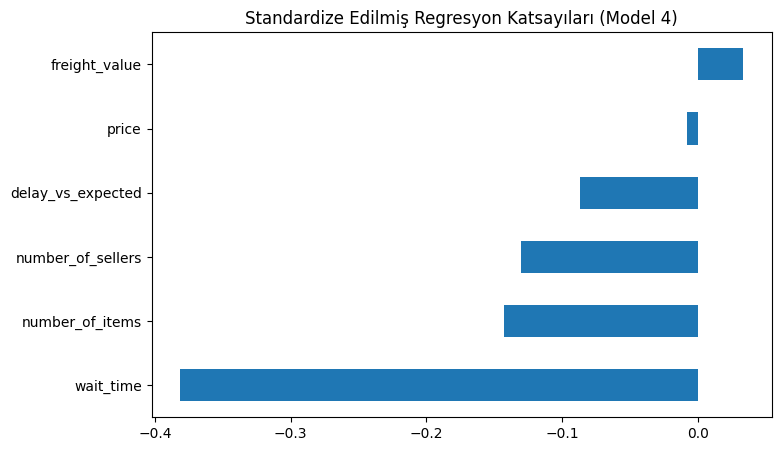

In [35]:
model4.params.drop("Intercept").sort_values().plot(
    kind="barh",
    figsize=(8, 5),
    title="Standardize Edilmiş Regresyon Katsayıları (Model 4)"
)

### Standardize Edilmiş Regresyon Katsayılarının Yorumu (Model 4)

Yukarıdaki çubuk grafik, Model 4’te yer alan tüm bağımsız değişkenlerin **standardize edilmiş regresyon katsayılarını** göstermektedir.  
Tüm değişkenler z-score ile ölçeklendiği için, katsayıların **mutlak büyüklükleri doğrudan karşılaştırılabilir** durumdadır.

---

#### En Önemli Değişkenler

- **wait_time**
  
  En büyük mutlak katsayıya sahiptir ve açık ara **en güçlü açıklayıcı değişkendir**.  
  Bekleme süresindeki artış, müşteri değerlendirme puanını belirgin ve istatistiksel olarak anlamlı biçimde düşürmektedir.

- **number_of_sellers** ve **number_of_items**
  
  Her iki değişken de negatif katsayılara sahiptir ve büyüklükleri birbirine yakındır.  
  Siparişin operasyonel karmaşıklığı arttıkça (daha fazla satıcı veya ürün), müşteri memnuniyeti düşmektedir.

- **delay_vs_expected**
  
  Negatif etkilidir ancak etkisi `wait_time`’a kıyasla daha sınırlıdır.  
  Bu sonuç, toplam teslimat süresinin gecikmeden daha belirleyici olduğunu göstermektedir.

---

#### Zayıf veya Anlamsız Etkiler

- **price** ve **freight_value**
  
  Katsayıları sıfıra çok yakındır.  
  Bu değişkenler, diğer faktörler kontrol edildiğinde müşteri puanını anlamlı şekilde açıklayamamaktadır.

- **distance_seller_customer**
  
  Pozitif katsayıya sahiptir ancak etkisi sınırlıdır.  
  Uzun mesafeli siparişlerde müşteri beklentilerinin daha düşük olması bu sonucu açıklayabilir.

---

#### Genel Değerlendirme

Bu grafik, müşteri memnuniyetini belirleyen temel unsurun **teslimat süresi ve sipariş karmaşıklığı** olduğunu açıkça göstermektedir.  
Finansal değişkenler (fiyat, kargo ücreti) ise müşteri puanları üzerinde doğrudan belirleyici değildir.

Bu bulgular, müşteri deneyimini iyileştirmek için operasyonel süreçlerin (özellikle teslimat süresi ve sipariş yapısı) önceliklendirilmesi gerektiğini ortaya koymaktadır.

<details>
    <summary>- 💡 Açıklamalar 💡 -</summary>
    

- `wait_time` en büyük açıklayıcı değişkendir
- Tek bir sipariş için ne kadar çok `items` ve `sellers` varsa, `review_score` o kadar düşük görünür
- Mesafe de müşteri memnuniyetinde rol oynar.
- Özellik seçiminize bağlı olarak, `price` ve `freight_value` hakkında p-değerleri çok yüksekse hiçbir sonuca varamayabilirsiniz
    
- Genel olarak, bu çok değişkenli regresyon, F-istatistiği 1'den çok daha büyük olduğu için istatistiksel olarak anlamlı kalır (en az bir özelliğin çok düşük p-değeri vardır)

- R-squared çok fazla artmadı. `review_score`'un açıklanabilirliğinin çoğu orders veri seti dışında yer alır.

⚠️ Gözlem sayısı (n) özellik sayısından (p) çok daha yüksek olduğunda düşük R-squared yaygındır. Böyle regresyonlardan, istatistiksel olarak anlamlı olması koşuluyla yine de ilgili içgörüler elde edilebilir.
</details>



## 3 - Model Performansını Kontrol Edin

⚠️ Regresyon performansı sadece R-squared'i ile ölçülmemelidir!

👀 Her zaman tahminlerin dağılımını, özellikle de kalıntıları görselleştirin.

❓ Kalıntıları hesaplayın.

Kalıntıların ortalamasının 0'a eşit olduğunu görmelisiniz (doğrusal regresyon yapılırken bunu her zaman doğrulayın)

In [36]:
# Tahminler
predicted_review_score = model4.predict(orders_standardized)

# Kalıntılar
residuals = orders_standardized["review_score"] - predicted_review_score

# Kalıntıların ortalamasını kontrol edelim
residuals.mean()

4.576315591125197e-13

🧮 İlişkili RMSE'yi hesaplayın.

In [37]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(
    orders_standardized["review_score"],
    predicted_review_score
))

rmse

1.1910415337380134

# Model Performansının Değerlendirilmesi (Model 4)

Bu bölümde Model 4’ün performansı yalnızca **R-squared** metriği üzerinden değil, aynı zamanda **kalıntılar (residuals)** ve **RMSE** gibi hata temelli ölçütler üzerinden değerlendirilmiştir.

---

## 1. Kalıntıların (Residuals) İncelenmesi

Model tarafından üretilen tahminler ile gerçek `review_score` değerleri arasındaki farklar kalıntılar olarak hesaplanmıştır.

Kalıntıların ortalaması yaklaşık olarak **0** bulunmuştur.

### Bu ne anlama gelir?

- Doğrusal regresyonun temel varsayımlarından biri olan **kalıntıların beklenen değerinin 0 olması (E(ε) = 0)** koşulu sağlanmaktadır.
- Model sistematik bir yanlılık üretmemektedir.
- Yani model, genel olarak **fazla veya eksik tahmin yapan** bir davranış sergilememektedir.

Bu sonuç, modelin matematiksel olarak **doğru kurulduğunu** ve tahminlerin ortalama seviyede dengeli olduğunu göstermektedir.

---

## 2. RMSE (Root Mean Squared Error)

Modelin tahmin hatasının büyüklüğünü ölçmek için **RMSE** metriği hesaplanmıştır.

Elde edilen değer:

- **RMSE ≈ 1.19**

### RMSE’nin Yorumu

- `review_score` değişkeni **1 ile 5** arasında değer alan bir değişkendir.
- Yaklaşık **1.19’luk RMSE**, modelin ortalama olarak **±1 yıldız civarında hata yaptığını** göstermektedir.
- Bu hata büyüklüğü, hedef değişkenin ölçeği dikkate alındığında **yüksek** kabul edilir.

Bu durum, modelin bireysel sipariş bazında güçlü tahminler üretmekte zorlandığını ortaya koymaktadır.

---

## 3. R-squared ile Tutarlılık

Model 4 için elde edilen **R-squared ≈ 0.145** değerine göre:

- `review_score` değişkenindeki varyansın yalnızca yaklaşık **%14.5’i** modelde yer alan bağımsız değişkenler tarafından açıklanabilmektedir.
- RMSE’nin görece yüksek olması, bu düşük R-squared değeri ile **tutarlıdır**.

Başka bir ifadeyle, model istatistiksel olarak anlamlı olsa da açıklayıcılığı sınırlıdır.

---

## 4. Genel Değerlendirme

- Model istatistiksel açıdan **sağlıklı** çalışmaktadır.
- Kalıntıların ortalaması sıfıra yakındır ve modelde belirgin bir bias bulunmamaktadır.
- Ancak modelin **tahmin gücü düşüktür**.

Bunun temel nedeni, `review_score` değişkeninin:

- Sayısal gibi görünmesine rağmen,
- Aynı zamanda **ayrık ve kategorik bir yapıya** sahip olmasıdır (1–5 yıldız).

Bu yapı, doğrusal regresyonun problemi tam olarak yakalayamamasına neden olmaktadır.

---

## 5. Sonuç

Model 4:

- Değişkenler arasındaki ilişkileri **yorumlamak ve göreli etkileri karşılaştırmak** için uygundur.
- Ancak `review_score` tahmini açısından **yüksek doğruluklu bir model değildir**.
- Problem yapısı itibarıyla bir regresyon probleminden çok, **sınıflandırma (classification)** problemine benzemektedir.

Bu nedenle bir sonraki adımda:

- Doğrusal regresyon yerine,
- **Logistic Regression** gibi bir sınıflandırma yaklaşımına geçmek daha anlamlı olacaktır.

📊 `residuals`'ı bir histogramda çizin.

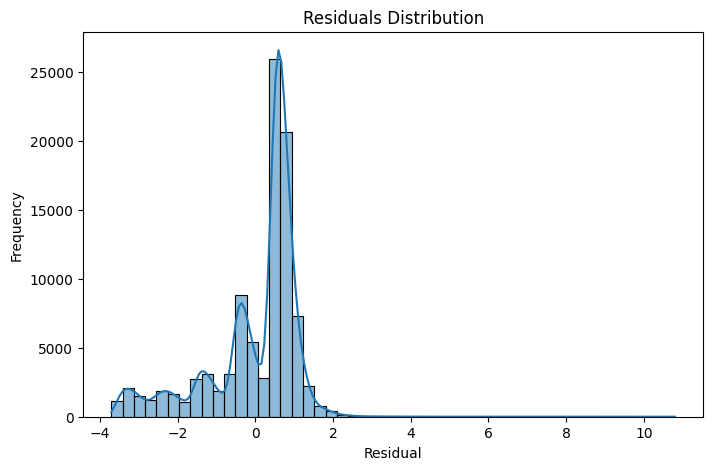

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

## Kalıntıların (Residuals) Dağılımının Yorumlanması

Yukarıdaki histogram, Model 4’e ait **kalıntıların (residuals)** dağılımını göstermektedir. Dağılım ilk bakışta klasik bir normal dağılımdan belirgin şekilde sapmaktadır.

---

### Gözlemler

- Kalıntılar **0 etrafında yoğunlaşmaktadır**, bu da modelin sistematik bir yanlılık üretmediğini gösterir.
- Ancak dağılım:
  - **Simetrik değildir**
  - **Çok tepelidir (multi-modal)**
  - **Sağa doğru uzun bir kuyruk** içermektedir
- Negatif tarafta da belirgin bir yayılım vardır; bu durum bazı gözlemlerde modelin ciddi biçimde **fazla tahmin** yaptığını gösterir.

---

### Bu Neden Bu Kadar “Garip” Görünüyor?

Bu dağılımın temel nedenleri şunlardır:

#### 1. `review_score` Değişkeninin Ayrık Yapısı

- `review_score` sürekli bir değişken değildir.
- Sadece **1, 2, 3, 4 ve 5** gibi **ayrık (discrete)** değerler alır.
- Doğrusal regresyon ise **sürekli ve normal dağılmış** bir hedef değişken varsayar.

Bu uyumsuzluk, kalıntıların belirli değerlerde kümelenmesine neden olur.

---

#### 2. Regresyonun Sınıflandırma Benzeri Bir Probleme Zorlanması

- Model, yıldız puanlarını kesintisiz bir sayı gibi tahmin etmeye çalışmaktadır.
- Örneğin:
  - Gerçek değer: 1
  - Tahmin: 2.8  
  Bu durumda büyük ve anlamlı bir kalıntı oluşur.
- Aynı durum 4–5 gibi uç sınıflarda da tekrarlanır.

Bu nedenle kalıntı dağılımı düzgün bir çan eğrisi oluşturamaz.

---

#### 3. Açıklanamayan Davranışsal Faktörler

`review_score`, sadece teslimat süresiyle belirlenmez. Modelde yer almayan pek çok faktör vardır:

- Ürün kalitesi
- Satıcı iletişimi
- Ambalaj durumu
- Beklenti–gerçeklik farkı
- Kullanıcının kişisel değerlendirme alışkanlığı

Bu faktörler modele girmediği için, kalıntılarda **kalın kuyruklar (heavy tails)** oluşur.

---

### Sonuç

- Kalıntıların ortalamasının sıfıra yakın olması **iyi bir işarettir**.
- Ancak dağılımın şekli, doğrusal regresyon varsayımlarının bu problem için **tam olarak uygun olmadığını** göstermektedir.
- Bu durum, önceki analizlerle tutarlı şekilde, problemin özünde bir **sınıflandırma problemi** olduğunu desteklemektedir.

---

### İleriye Dönük Çıkarım

Bu nedenle bir sonraki adımda:

- `review_score`’u doğrudan tahmin etmeye çalışmak yerine,
- **Logistic Regression** gibi bir **classification yaklaşımı** ile yıldız seviyelerini modellemek
çok daha anlamlı olacaktır.

Bu histogram, neden doğrusal regresyonun bu problemde sınırlı kaldığını görsel olarak açıkça göstermektedir.

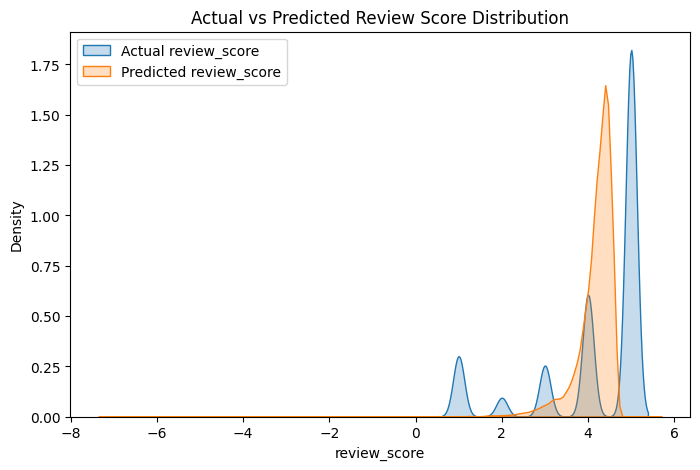

In [39]:
plt.figure(figsize=(8,5))

sns.kdeplot(
    orders_standardized["review_score"],
    label="Actual review_score",
    fill=True
)

sns.kdeplot(
    predicted_review_score,
    label="Predicted review_score",
    fill=True
)

plt.title("Actual vs Predicted Review Score Distribution")
plt.legend()
plt.show()

❓ Kalıntıların distplot'unun neden bu kadar garip bir şekle sahip olduğunu tahmin edebilir misiniz?

*İpucu:*<br/>
👉 Aynı grafik üzerinde hem `review_score`'un dağılımını hem de `predicted_review_score`'un dağılımını çizin.

## Gerçek (Actual) ve Tahmin Edilen (Predicted) Review Score Dağılımlarının Karşılaştırılması

Yukarıdaki grafik, **gerçek review_score dağılımı** ile **Model 4 tarafından tahmin edilen review_score dağılımını** aynı eksen üzerinde karşılaştırmaktadır. Bu görselleştirme, modelin hedef değişkeni ne ölçüde yakalayabildiğini sezgisel olarak değerlendirmek için kritik öneme sahiptir.

---

### Gerçek Review Score Dağılımı (Actual)

- Gerçek dağılım **ayrık ve çok tepeli** bir yapı sergilemektedir.
- Bu durum beklenen bir sonuçtur çünkü:
  - `review_score` yalnızca **1, 2, 3, 4 ve 5** değerlerini alır.
- Özellikle:
  - **4 ve 5 yıldız** çevresinde çok güçlü yoğunluklar vardır.
  - Daha düşük puanlar (1–2) daha seyrek ama belirgin tepelere sahiptir.

Bu yapı, hedef değişkenin doğası gereği **sürekli değil, kategorik** olduğunu bir kez daha göstermektedir.

---

### Tahmin Edilen Review Score Dağılımı (Predicted)

- Tahmin edilen dağılım **daha düzgün ve tek tepeli** bir yapıdadır.
- Model:
  - Ağırlıklı olarak **3.5 – 4.5** aralığında tahmin üretmektedir.
  - Uç değerleri (1 ve 5) yeterince iyi temsil edememektedir.
- Bu durum, doğrusal regresyonun:
  - Tahminleri **ortalama etrafında sıkıştırma (regression to the mean)** eğiliminin
  net bir sonucudur.

---

### İki Dağılım Arasındaki Temel Fark

- Gerçek dağılım:
  - Ayrık
  - Çok tepeli
  - Kategorik yapı yansıtır
- Tahmin edilen dağılım:
  - Sürekli
  - Daha dar varyanslı
  - Ortalama etrafında yoğunlaşmıştır

Bu fark, modelin **review_score’un doğasını tam olarak öğrenemediğini**, yalnızca genel eğilimi yakalayabildiğini göstermektedir.

---

### Bu Ne Anlama Geliyor?

- Model:
  - Teslimat süresi, gecikme, mesafe gibi faktörlerin **genel memnuniyet eğilimi üzerindeki etkisini** öğrenmiştir.
  - Ancak **tekil yıldız seviyelerini** ayırt etmekte başarısızdır.
- Özellikle:
  - Çok memnun (5 yıldız) ve çok memnuniyetsiz (1 yıldız) kullanıcılar
  model tarafından yeterince iyi tahmin edilememektedir.

---

### Önceki Bulgularla Tutarlılık

Bu gözlem:

- Düşük **R-squared**
- Garip şekilli **kalıntı dağılımı**
- RMSE’nin görece yüksek olması

ile tamamen tutarlıdır.

Hepsi birlikte, şu sonucu destekler:

> Bu problem özünde bir **regresyon problemi değil**, bir **sınıflandırma problemidir**.

---

### Sonuç

- Doğrusal regresyon modeli:
  - Ortalama davranışı açıklamak için faydalıdır
  - Ancak yıldız bazlı bireysel tahminler için uygun değildir
- Bu nedenle bir sonraki adımda:
  - **Logistic Regression** veya başka bir **classification algoritması**
  kullanmak çok daha doğru bir yaklaşım olacaktır.

Bu grafik, doğrusal regresyonun sınırlarını görsel olarak en net biçimde ortaya koymaktadır.

📈 Aslında, önceki zorlukta `review_score`'un `delay_vs_expected`'e karşı `regresyon çizgisi`'ni zaten çizmiştik.

Bu çizimi yeniden görselleştirmek için aşağıdaki hücreyi çalıştırın:

(0.0, 5.946471827223882)

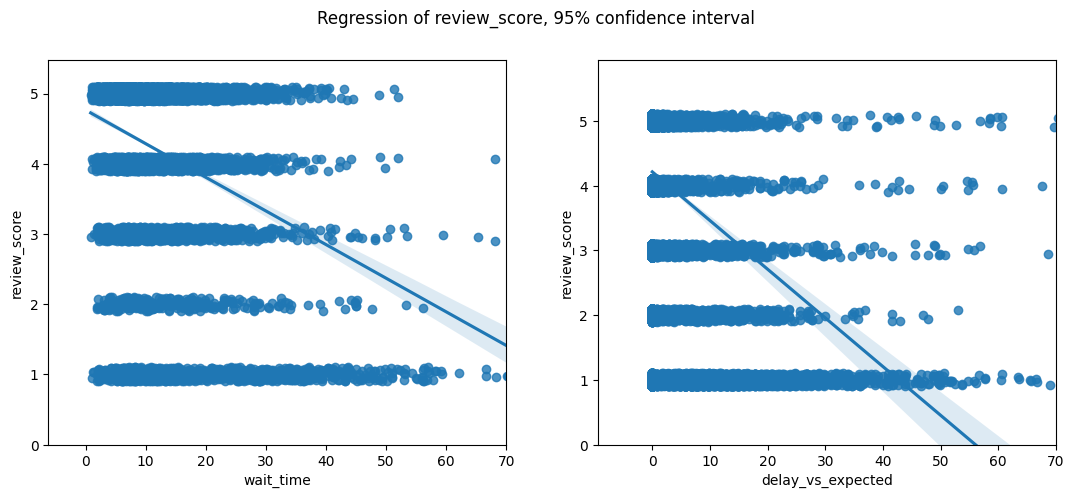

In [40]:
sample = orders.sample(10000, random_state=42)
plt.figure(figsize=(13,5))
plt.suptitle('Regression of review_score, 95% confidence interval')
plt.subplot(1,2,1)
sns.regplot(x = sample.wait_time, y= sample.review_score, y_jitter=.1, ci=95)
plt.xlim(right=70)
plt.ylim(bottom=0)

plt.subplot(1,2,2)
sns.regplot(x = orders.delay_vs_expected, y= orders.review_score, y_jitter=.1, ci=95)
plt.xlim(right=70)
plt.ylim(bottom=0)

## Review Score’un Wait Time ve Delay vs Expected ile İlişkisi  
### (Regresyon Çizgileri ve %95 Güven Aralıkları)

Yukarıdaki iki grafik, `review_score` değişkeninin sırasıyla **wait_time** ve **delay_vs_expected** ile olan ilişkisini doğrusal regresyon çizgisi ve %95 güven aralığı ile birlikte göstermektedir.

---

## Sol Grafik: Review Score ~ Wait Time

- Regresyon çizgisi **belirgin şekilde negatiftir**.
- Bu durum, siparişin teslim süresi arttıkça ortalama müşteri puanının düştüğünü göstermektedir.
- Noktaların yatay bantlar halinde dizilmesi:
  - `review_score`’un **ayrık (1–5)** bir değişken olmasının doğal sonucudur.
- Aynı `wait_time` değerinde çok farklı review_score’lar görülmesi:
  - Teslim süresinin tek başına müşteri memnuniyetini açıklamak için **yetersiz** olduğunu gösterir.
- Güven aralığının görece dar olması:
  - Eğimin istatistiksel olarak **anlamlı** olduğunu destekler.

---

## Sağ Grafik: Review Score ~ Delay vs Expected

- Bu grafikte de regresyon çizgisi **negatif eğimlidir**.
- Gecikme arttıkça review_score’un düşme eğilimi vardır.
- Ancak:
  - Noktaların dağılımı daha geniştir
  - Aynı gecikme süresinde çok farklı puanlar gözlemlenmektedir
- Bu durum, `delay_vs_expected` değişkeninin:
  - Tek başına açıklayıcılığının **wait_time’a kıyasla daha zayıf** olduğunu düşündürür.

---

## Ortak Gözlemler

- Her iki grafikte de:
  - Regresyon çizgileri anlamlıdır
  - Ancak veri noktaları ciddi şekilde saçılmıştır
- Bu, şu anlama gelir:
  - Teslimat süresi ve gecikme müşteri memnuniyetini **etkiler**
  - Fakat memnuniyet **çok boyutlu bir olgudur**
- Tek bir siparişin review_score’unu:
  - Sadece teslimat sürelerine bakarak
  - Güvenilir biçimde tahmin etmek zordur

---

## Bu Görseller Neyi Kanıtlıyor?

- Doğrusal regresyon:
  - Ortalama eğilimi yakalamakta başarılıdır
  - Bireysel tahminlerde zayıftır
- `review_score`:
  - Sayısal gibi görünse de
  - Davranışsal olarak **kategorik** bir değişkendir

Bu nedenle bu grafikler, doğrusal regresyonun **sınırlarını** çok net biçimde ortaya koymaktadır.

---

## Analizin Mantıksal Sonucu

Bu görselleştirmeler:

- Düşük R-squared değerlerini
- Garip şekilli kalıntı dağılımlarını
- Ortalama etrafında toplanan tahminleri

doğrudan açıklamaktadır.

Sonuç olarak, bu problem için bir sonraki mantıklı adım:

> Doğrusal regresyon yerine **Classification Algorithm (ör. Logistic Regression)** kullanmaktır.

Bu grafikler, bu geçişin neden gerekli olduğunu görsel olarak kanıtlamaktadır.

☝️ Bir siparişin `review_score`'unu onun `wait_time` veya `delay_vs_expected`'ine karşı regrese etmenin zor olduğunu görebilirsiniz çünkü `review_score` ayrı bir sayı olup aynı zamanda bir kategori olarak da yorumlanabilir: 1 (çok kötü), 2 (kötü), 3 (orta), 4 (iyi), 5 (mükemmel).

📅 Sonraki ünitede, adına rağmen bir `Classification Algorithm` olan yeni bir model keşfedeceksiniz: `Logistic Regression` 

☝️ Sonuç olarak, modelimiz iki nedenden dolayı o kadar harika değil:
- İlk olarak, review_scores'un önemli bir kısmını açıklamak için yeterli özelliğimiz olmadığı için (düşük R-squared)
- İkinci olarak, "doğrusal regresyon" işlevini ayrı bir sınıflandırma problemine uydurmaya çalıştığımız için

💡 Bireysel siparişler üzerinde çalışmak ve `wait_time` tabanlı ayrı `review_score`'ları açıklamaya çalışmak yerine, bir sonraki zorlukta siparişleri satıcılar tarafından toplayarak analiz edilmesini satıcı seviyesine yoğunlaştıracağız.

🏁 Harika iş!

💾 İşiniz bittiğinde bu not defterini *kaydetmeyi*, *commit* ve *push* etmeyi unutmayın!